In [1]:
import pandas as pd
import numpy as np
import re
import category_encoders as encoders
from collections import Counter
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, KFold
import seaborn as sns
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
df.drop(['Id'], axis=1, inplace=True)
df.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [3]:
# Split X and y
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

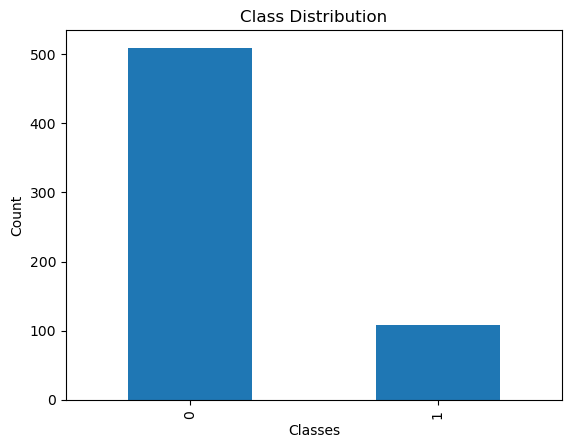

In [4]:
# Assuming y is a pandas Series or DataFrame column containing the target labels
class_counts = y.value_counts()
class_counts.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [5]:
# encode EJ column in onehotencoder
encoder = encoders.OneHotEncoder(cols=["EJ"])
encoder.fit(X)
X_encoded = encoder.transform(X)
X_encoded

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,9.879296,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000
613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.910227,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340
614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,12.029366,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000
615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,8.026928,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622


In [6]:
deleted_column_names = ["CC","EJ_1","GL"]
X_encoded = X_encoded.drop(deleted_column_names,axis=1)

In [7]:
# Assuming 'X_encoded' is your dataset with NaN values
# Step 1: Identify NaN positions
nan_positions = np.isnan(X_encoded)

# Step 2: Compute the mean of each column
column_means = np.nanmean(X_encoded, axis=0)

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X_encoded = imputer.fit_transform(X_encoded)

In [8]:
positive_records = y.sum()
negative_records = len(y) - positive_records
estimate = negative_records / positive_records
print('y Estimate: %.3f' % estimate)

y Estimate: 4.713


In [9]:
model = XGBClassifier(colsample_bylevel = 0.6, 
                      colsample_bytree = 1.0, 
                      learning_rate = 0.27, 
                      max_depth = 2, 
                      n_estimators = 153, 
                      subsample = 1.0,   
                      scale_pos_weight = 5,
                      eval_metric = ["error", "logloss"],
                      reg_alpha=1.0
                     )

In [10]:
model.fit(X_encoded, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['error', 'logloss'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.27, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=153, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [11]:
# Helper function for nested cross-validation
def nested_cross_val_score(model, X, y, outer_folds=5, inner_folds=5, param_distributions=None):
    outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=0)
    inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=0)

    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)
    
    # Inside the function, create a RandomizedSearchCV object instead of GridSearchCV
    if param_distributions is not None:
        model = RandomizedSearchCV(model, param_distributions, cv=inner_cv, scoring='neg_log_loss', n_iter=10, n_jobs=-1)
  
    inner_cv_scores = []
    outer_cv_scores = []

    for outer_train_index, outer_test_index in outer_cv.split(X, y):
        X_outer_train, X_outer_test = X.iloc[outer_train_index], X.iloc[outer_test_index]
        y_outer_train, y_outer_test = y.iloc[outer_train_index], y.iloc[outer_test_index]

        inner_cv_scores_outer_fold = []

        for inner_train_index, inner_test_index in inner_cv.split(X_outer_train, y_outer_train):
            X_inner_train, X_inner_test = X_outer_train.iloc[inner_train_index], X_outer_train.iloc[inner_test_index]
            y_inner_train, y_inner_test = y_outer_train.iloc[inner_train_index], y_outer_train.iloc[inner_test_index]

            model.fit(X_inner_train, y_inner_train)
            y_inner_pred = model.predict(X_inner_test)
            inner_cv_scores_outer_fold.append(np.mean(y_inner_pred != y_inner_test))

        inner_cv_scores.append(np.mean(inner_cv_scores_outer_fold))

        model.fit(X_outer_train, y_outer_train)
        y_outer_pred = model.predict(X_outer_test)
        outer_cv_scores.append(np.mean(y_outer_pred != y_outer_test))

    return np.mean(outer_cv_scores), np.std(outer_cv_scores), np.mean(inner_cv_scores), np.std(inner_cv_scores)

In [12]:
from sklearn.model_selection import KFold, RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

def hyperparameter_tunning_with_nested_cv(X_encoded, y):

    # Define the hyperparameter distributions for XGBoost
    param_distributions = {
        'learning_rate': np.arange(0.1, 0.5, 0.01),
        'max_depth': np.arange(2, 5),
        'n_estimators': np.arange(100, 300),
        'subsample': [1],
        'colsample_bylevel': [0.6],
        'colsample_bytree': [1],
        'reg_alpha':  [1],
        'scale_pos_weight': [5],
        'eval_metric': [["error", "logloss"]]
    }

    # Create the XGBClassifier instance
    model = XGBClassifier(colsample_bylevel=0.6, colsample_bytree=1.0, eval_metric=["error", "logloss"])

    # Create the RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=100,  # Number of random searches to perform (you can adjust this value)
        scoring="neg_log_loss",  # Use log loss as the evaluation metric
        cv=KFold(n_splits=5, shuffle=True, random_state=42),  # Use KFold for cross-validation
        random_state=42
    )

    # Run nested cross-validation using the RandomizedSearchCV with the hyperparameter distributions
    outer_mean_logloss, outer_std_logloss, inner_mean_logloss, inner_std_logloss = nested_cross_val_score(
        random_search, X_encoded, y
    )

    # Print the results
    print("Nested Cross-Validation Results:")
    print("Outer CV Mean Log Loss: {:.4f} (±{:.4f})".format(outer_mean_logloss, outer_std_logloss))
    print("Inner CV Mean Log Loss: {:.4f} (±{:.4f})".format(inner_mean_logloss, inner_std_logloss))

    # Get the best hyperparameters from the RandomizedSearchCV object
    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Train the final model on the entire dataset with the best hyperparameters
    model = XGBClassifier(**best_params)
    model.fit(X_encoded, y)
    
    return model


In [13]:
def feature_reduction(model, X_encoded):
    
    # Get the feature importances from the trained model
    feature_importances = model.feature_importances_

    # Sort features based on importance (descending order)
    sorted_indices = feature_importances.argsort()[::-1]

    # Set a threshold for feature selection based on importance scores
    threshold = 0.01  # You can adjust the threshold as needed

    # Select features based on the importance scores
    selected_indices = sorted_indices[feature_importances[sorted_indices] > threshold]

    # Get the names of the selected features
    selected_feature_names = X_encoded.columns[selected_indices]

    # Use the selected features for training your model
    X_selected = X_encoded[selected_feature_names]
    
    return X_selected

In [14]:
def print_importance(model,X_encoded):
    
    # Get the feature importance values using the feature_importances_ attribute
    importance_values = model.feature_importances_

    # Get the names of the features in the same order as the importance values
    feature_names = X_encoded.columns

    # Create a dictionary to store feature importance values with their corresponding feature names
    importance_dict = dict(zip(feature_names, importance_values))

    # Sort the features based on their importance values in descending order
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=False)

    # Separate the feature names and importance values for plotting
    sorted_feature_names, sorted_importance_values = zip(*sorted_importance)

    # Plot the feature importances
    plt.figure(figsize=(15,15))  # Set the figure size as needed
    plt.barh(range(len(sorted_importance_values)), sorted_importance_values, align='center')
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances')
    plt.show()    

In [15]:
# Run nested cross-validation
outer_mean_logloss, outer_std_logloss, inner_mean_logloss, inner_std_logloss = nested_cross_val_score(model, X_encoded, y)

# Print the results
print("Original Nested Cross-Validation Results:")
print("Outer CV Mean Log Loss: {:.4f} (±{:.4f})".format(outer_mean_logloss, outer_std_logloss))
print("Inner CV Mean Log Loss: {:.4f} (±{:.4f})".format(inner_mean_logloss, inner_std_logloss))
print(" ")

# model = hyperparameter_tunning_with_nested_cv(X_encoded, y)

Original Nested Cross-Validation Results:
Outer CV Mean Log Loss: 0.0681 (±0.0238)
Inner CV Mean Log Loss: 0.0741 (±0.0047)
 


# fit optimized model with hiperparamters tunned and feature reduced
model = XGBClassifier(colsample_bylevel = 0.1, 
                      colsample_bytree = 0.1, 
                      learning_rate = 0.11, 
                      max_depth = 3, 
                      n_estimators = 295, 
                      subsample = 0.1,   
                      scale_pos_weight = 5,
                      eval_metric = ["error", "logloss"],
                      reg_alpha=0.1
                     )

model.fit(X_encoded, y)

# Submit

In [16]:
test_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
test_df_2 = test_df.drop(['Id'], axis = 1)
encoded_test_df = encoder.transform(test_df_2)
encoded_test_df = encoded_test_df.drop(deleted_column_names,axis=1)
encoded_test_df = imputer.fit_transform(encoded_test_df)
encoded_test_df

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
    

In [17]:
# predict
predictions = model.predict_proba(encoded_test_df)
class_0_pred = predictions[:,0]
class_1_pred = predictions[:,1]

# build submission_df
test_df["class_0"] = pd.Series(class_0_pred).values
test_df["class_1"] = pd.Series(class_1_pred).values
submission_df = test_df[["Id", "class_0", "class_1"]]
submission_df

,Id,class_0,class_1
0,00eed32682bb,0.76944,0.23056
1,010ebe33f668,0.76944,0.23056
2,02fa521e1838,0.76944,0.23056
3,040e15f562a2,0.76944,0.23056
4,046e85c7cc7f,0.76944,0.23056


In [18]:
submission_df.to_csv("/kaggle/working/submission.csv", index=False)